# **MIT 6.5940 EfficientML.ai Fall 2023 Lab 2: Quantization**

This colab notebook provides code and a framework for Lab 2 quantization. You can work out your solutions here.

Please fill out this [feedback form](https://forms.gle/ZeCH5anNPrkd5wpp7) when you finished this lab. We would love to hear your thoughts or feedback on how we can improve this lab!

## Goals

In this assignment, you will practice quantizing a classical neural network model to reduce both model size and latency. The goals of this assignment are as follows:

- Understand the basic concept of **quantization**
- Implement and apply **k-means quantization**
- Implement and apply **quantization-aware training** for k-means quantization
- Implement and apply **linear quantization**
- Implement and apply **integer-only inference** for linear quantization
- Get a basic understanding of performance improvement (such as speedup) from quantization
- Understand the differences and tradeoffs between these quantization approaches

## Contents


There are 2 main sections: ***K-Means Quantization*** and ***Linear Quantization***.

There are ***10*** questions in total:
- For *K-Means Quantization*, there are ***3*** questions (Question 1-3).
- For *Linear Quantization*, there are ***6*** questions (Question 4-9).
- Question 10 compares k-means quantization and linear quantization.

# Setup

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and VGG network which is the same as what we used in the Lab 0 tutorial.



In [1]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('Installing fast-pytorch-kmeans...')
! pip install fast-pytorch-kmeans 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
Installing fast-pytorch-kmeans...
All required packages have been successfully installed!


In [2]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

/home/lhmd/anaconda3/envs/TinyML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [4]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys
    from urllib.request import urlretrieve
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [5]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))
    add("avgpool", nn.AvgPool2d(2))
    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    # x = x.mean([2, 3])
    x = x.view(x.shape[0], -1)

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [6]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [7]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  extra_preprocess = None
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    if extra_preprocess is not None:
        for preprocess in extra_preprocess:
            inputs = preprocess(inputs)

    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    # print(outputs, targets)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helpler Functions (Flops, Model Size calculation, etc.)

In [8]:
def get_model_flops(model, inputs):
    num_macs = profile_macs(model, inputs)
    return num_macs

In [9]:
def get_model_size(model: nn.Module, data_width=32):
    """
    calculate the model size in bits
    :param data_width: #bits per element
    """
    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define misc funcions for verification.

In [10]:
def test_k_means_quantize(
    test_tensor=torch.tensor([
        [-0.3747,  0.0874,  0.3200, -0.4868,  0.4404],
        [-0.0402,  0.2322, -0.2024, -0.4986,  0.1814],
        [ 0.3102, -0.3942, -0.2030,  0.0883, -0.4741],
        [-0.1592, -0.0777, -0.3946, -0.2128,  0.2675],
        [ 0.0611, -0.1933, -0.4350,  0.2928, -0.1087]]),
    bitwidth=2):
    def plot_matrix(tensor, ax, title, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=-0.5, vmax=0.5, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    fig, axes = plt.subplots(1,2, figsize=(8, 12))
    ax_left, ax_right = axes.ravel()

    print(test_tensor)
    plot_matrix(test_tensor, ax_left, 'original tensor')

    num_unique_values_before_quantization = test_tensor.unique().numel()
    k_means_quantize(test_tensor, bitwidth=bitwidth)
    num_unique_values_after_quantization = test_tensor.unique().numel()
    print('* Test k_means_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        num unique values before k-means quantization: {num_unique_values_before_quantization}')
    print(f'        num unique values after  k-means quantization: {num_unique_values_after_quantization}')
    assert num_unique_values_after_quantization == min((1 << bitwidth), num_unique_values_before_quantization)
    print('* Test passed.')

    plot_matrix(test_tensor, ax_right, f'{bitwidth}-bit k-means quantized tensor', cmap='tab20c')
    fig.tight_layout()
    plt.show()

In [11]:
def test_linear_quantize(
    test_tensor=torch.tensor([
        [ 0.0523,  0.6364, -0.0968, -0.0020,  0.1940],
        [ 0.7500,  0.5507,  0.6188, -0.1734,  0.4677],
        [-0.0669,  0.3836,  0.4297,  0.6267, -0.0695],
        [ 0.1536, -0.0038,  0.6075,  0.6817,  0.0601],
        [ 0.6446, -0.2500,  0.5376, -0.2226,  0.2333]]),
    quantized_test_tensor=torch.tensor([
        [-1,  1, -1, -1,  0],
        [ 1,  1,  1, -2,  0],
        [-1,  0,  0,  1, -1],
        [-1, -1,  1,  1, -1],
        [ 1, -2,  1, -2,  0]], dtype=torch.int8),
    real_min=-0.25, real_max=0.75, bitwidth=2, scale=1/3, zero_point=-1):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fig, axes = plt.subplots(1,3, figsize=(10, 32))
    plot_matrix(test_tensor, axes[0], 'original tensor', vmin=real_min, vmax=real_max)
    _quantized_test_tensor = linear_quantize(
        test_tensor, bitwidth=bitwidth, scale=scale, zero_point=zero_point)
    _reconstructed_test_tensor = scale * (_quantized_test_tensor.float() - zero_point)
    print('* Test linear_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        scale: {scale}')
    print(f'        zero point: {zero_point}')
    assert _quantized_test_tensor.equal(quantized_test_tensor)
    print('* Test passed.')
    plot_matrix(_quantized_test_tensor, axes[1], f'2-bit linear quantized tensor',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(_reconstructed_test_tensor, axes[2], f'reconstructed tensor',
                vmin=real_min, vmax=real_max, cmap='tab20c')
    fig.tight_layout()
    plt.show()


In [12]:
def test_quantized_fc(
    input=torch.tensor([
        [0.6118, 0.7288, 0.8511, 0.2849, 0.8427, 0.7435, 0.4014, 0.2794],
        [0.3676, 0.2426, 0.1612, 0.7684, 0.6038, 0.0400, 0.2240, 0.4237],
        [0.6565, 0.6878, 0.4670, 0.3470, 0.2281, 0.8074, 0.0178, 0.3999],
        [0.1863, 0.3567, 0.6104, 0.0497, 0.0577, 0.2990, 0.6687, 0.8626]]),
    weight=torch.tensor([
        [ 1.2626e-01, -1.4752e-01,  8.1910e-02,  2.4982e-01, -1.0495e-01,
         -1.9227e-01, -1.8550e-01, -1.5700e-01],
        [ 2.7624e-01, -4.3835e-01,  5.1010e-02, -1.2020e-01, -2.0344e-01,
          1.0202e-01, -2.0799e-01,  2.4112e-01],
        [-3.8216e-01, -2.8047e-01,  8.5238e-02, -4.2504e-01, -2.0952e-01,
          3.2018e-01, -3.3619e-01,  2.0219e-01],
        [ 8.9233e-02, -1.0124e-01,  1.1467e-01,  2.0091e-01,  1.1438e-01,
         -4.2427e-01,  1.0178e-01, -3.0941e-04],
        [-1.8837e-02, -2.1256e-01, -4.5285e-01,  2.0949e-01, -3.8684e-01,
         -1.7100e-01, -4.5331e-01, -2.0433e-01],
        [-2.0038e-01, -5.3757e-02,  1.8997e-01, -3.6866e-01,  5.5484e-02,
          1.5643e-01, -2.3538e-01,  2.1103e-01],
        [-2.6875e-01,  2.4984e-01, -2.3514e-01,  2.5527e-01,  2.0322e-01,
          3.7675e-01,  6.1563e-02,  1.7201e-01],
        [ 3.3541e-01, -3.3555e-01, -4.3349e-01,  4.3043e-01, -2.0498e-01,
         -1.8366e-01, -9.1553e-02, -4.1168e-01]]),
    bias=torch.tensor([ 0.1954, -0.2756,  0.3113,  0.1149,  0.4274,  0.2429, -0.1721, -0.2502]),
    quantized_bias=torch.tensor([ 3, -2,  3,  1,  3,  2, -2, -2], dtype=torch.int32),
    shifted_quantized_bias=torch.tensor([-1,  0, -3, -1, -3,  0,  2, -4], dtype=torch.int32),
    calc_quantized_output=torch.tensor([
        [ 0, -1,  0, -1, -1,  0,  1, -2],
        [ 0,  0, -1,  0,  0,  0,  0, -1],
        [ 0,  0,  0, -1,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  0,  1, -1, -2]], dtype=torch.int8),
    bitwidth=2, batch_size=4, in_channels=8, out_channels=8):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")

    output = torch.nn.functional.linear(input, weight, bias)

    quantized_weight, weight_scale, weight_zero_point = \
        linear_quantize_weight_per_channel(weight, bitwidth)
    quantized_input, input_scale, input_zero_point = \
        linear_quantize_feature(input, bitwidth)
    _quantized_bias, bias_scale, bias_zero_point = \
        linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale)
    assert _quantized_bias.equal(_quantized_bias)
    _shifted_quantized_bias = \
        shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point)
    assert _shifted_quantized_bias.equal(shifted_quantized_bias)
    quantized_output, output_scale, output_zero_point = \
        linear_quantize_feature(output, bitwidth)

    _calc_quantized_output = quantized_linear(
        quantized_input, quantized_weight, shifted_quantized_bias,
        bitwidth, bitwidth,
        input_zero_point, output_zero_point,
        input_scale, weight_scale, output_scale)
    assert _calc_quantized_output.equal(calc_quantized_output)

    reconstructed_weight = weight_scale * (quantized_weight.float() - weight_zero_point)
    reconstructed_input = input_scale * (quantized_input.float() - input_zero_point)
    reconstructed_bias = bias_scale * (quantized_bias.float() - bias_zero_point)
    reconstructed_calc_output = output_scale * (calc_quantized_output.float() - output_zero_point)

    fig, axes = plt.subplots(3,3, figsize=(15, 12))
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    plot_matrix(weight, axes[0, 0], 'original weight', vmin=-0.5, vmax=0.5)
    plot_matrix(input.t(), axes[1, 0], 'original input', vmin=0, vmax=1)
    plot_matrix(output.t(), axes[2, 0], 'original output', vmin=-1.5, vmax=1.5)
    plot_matrix(quantized_weight, axes[0, 1], f'{bitwidth}-bit linear quantized weight',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(quantized_input.t(), axes[1, 1], f'{bitwidth}-bit linear quantized input',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(calc_quantized_output.t(), axes[2, 1], f'quantized output from quantized_linear()',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(reconstructed_weight, axes[0, 2], f'reconstructed weight',
                vmin=-0.5, vmax=0.5, cmap='tab20c')
    plot_matrix(reconstructed_input.t(), axes[1, 2], f'reconstructed input',
                vmin=0, vmax=1, cmap='tab20c')
    plot_matrix(reconstructed_calc_output.t(), axes[2, 2], f'reconstructed output',
                vmin=-1.5, vmax=1.5, cmap='tab20c')

    print('* Test quantized_fc()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'      batch size: {batch_size}')
    print(f'      input channels: {in_channels}')
    print(f'      output channels: {out_channels}')
    print('* Test passed.')
    fig.tight_layout()
    plt.show()

Load Pretrained Model

In [13]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = (VGG()).cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda : model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


/tmp/ipykernel_170184/1160320635.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")


In [14]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


# Let's First Evaluate the Accuracy and Model Size of the FP32 Model

In [15]:
fp32_model_accuracy = evaluate(model, dataloader['test'])
fp32_model_size = get_model_size(model)
print(f"fp32 model has accuracy={fp32_model_accuracy:.2f}%")
print(f"fp32 model has size={fp32_model_size/MiB:.2f} MiB")

fp32 model has accuracy=92.95%
fp32 model has size=35.20 MiB


# K-Means Quantization

Network quantization compresses the network by reducing the bits per weight required to represent the deep network. The quantized network can have a faster inference speed with hardware support.

In this section, we will explore the K-means quantization for neural networks as in [Deep Compression: Compressing Deep Neural Networks With Pruning, Trained Quantization
And Huffman Coding](https://arxiv.org/pdf/1510.00149.pdf).


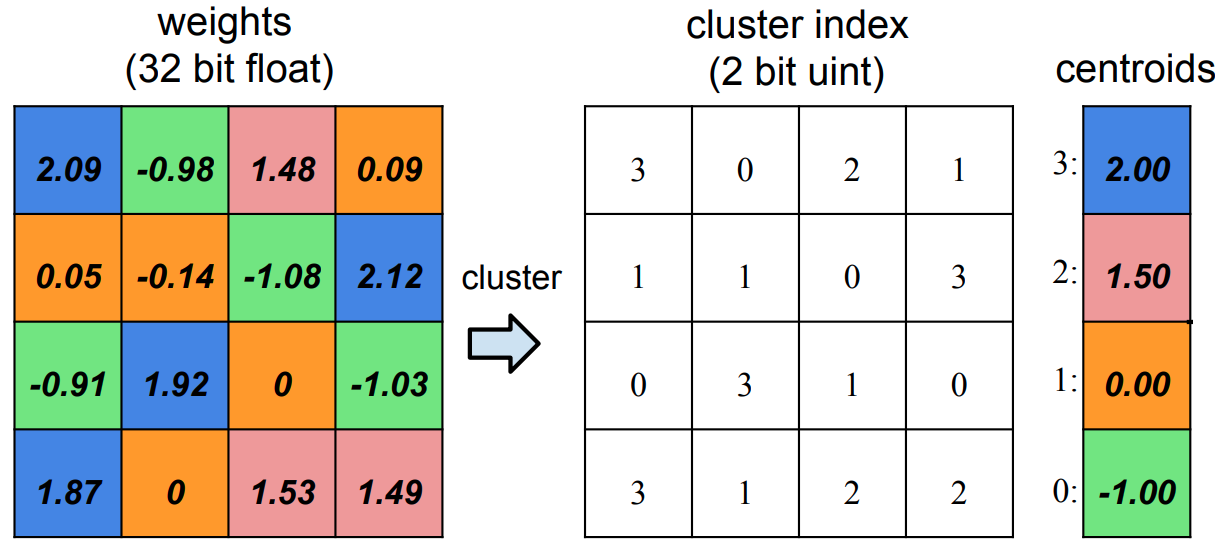

A $n$-bit k-means quantization will divide synapses into $2^n$ clusters, and synapses in the same cluster will share the same weight value.

Therefore, k-means quantization will create a codebook, inlcuding
*   `centroids`: $2^n$ fp32 cluster centers.
*   `labels`: a $n$-bit integer tensor with the same #elements of the original fp32 weights tensor. Each integer indicates which cluster it belongs to.

During the inference, a fp32 tensor is generated based on the codebook for inference:

> ***quantized_weight* = *codebook.centroids*\[*codebook.labels*\].view_as(weight)**

In [16]:
from collections import namedtuple

Codebook = namedtuple('Codebook', ['centroids', 'labels'])

## Question 1 (10 pts)

Please complete the following K-Means quantization function.

In [17]:
from fast_pytorch_kmeans import KMeans

def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=4, codebook=None):
    """
    quantize tensor using k-means clustering
    :param fp32_tensor:
    :param bitwidth: [int] quantization bit width, default=4
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] the cluster centroids
            labels: [torch.(cuda.)LongTensor] cluster label tensor
    """
    if codebook is None:
        ############### YOUR CODE STARTS HERE ###############
        # get number of clusters based on the quantization precision
        # hint: one line of code
        n_clusters = 2 ** bitwidth
        ############### YOUR CODE ENDS HERE #################
        # use k-means to get the quantization centroids
        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)
        centroids = kmeans.centroids.to(torch.float).view(-1)
        codebook = Codebook(centroids, labels)
    ############### YOUR CODE STARTS HERE ###############
    # decode the codebook into k-means quantized tensor for inference
    # hint: one line of code
    # print("codebook: ", codebook)
    quantized_tensor = codebook.centroids[codebook.labels].view_as(fp32_tensor)
    ############### YOUR CODE ENDS HERE #################
    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))
    return codebook

Let's verify the functionality of defined k-means quantization by applying the function above on a dummy tensor.

tensor([[-0.3747,  0.0874,  0.3200, -0.4868,  0.4404],
        [-0.0402,  0.2322, -0.2024, -0.4986,  0.1814],
        [ 0.3102, -0.3942, -0.2030,  0.0883, -0.4741],
        [-0.1592, -0.0777, -0.3946, -0.2128,  0.2675],
        [ 0.0611, -0.1933, -0.4350,  0.2928, -0.1087]])
* Test k_means_quantize()
    target bitwidth: 2 bits
        num unique values before k-means quantization: 25
        num unique values after  k-means quantization: 4
* Test passed.


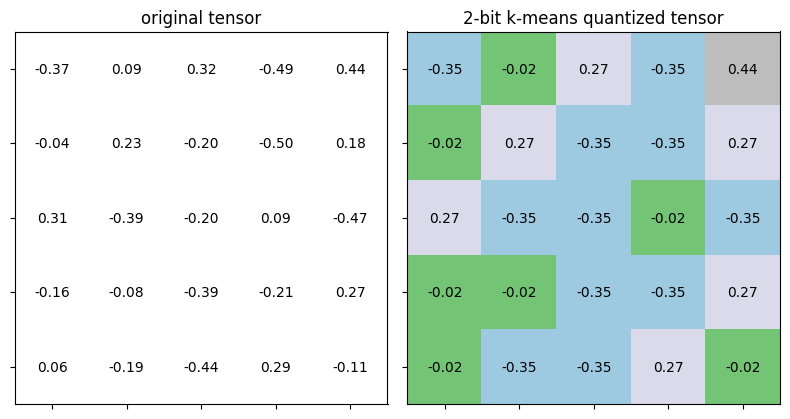

In [18]:
test_k_means_quantize()

## Question 2 (10 pts)

The last code cell performs 2-bit k-means quantization and plots the tensor before and after the quantization. Each cluster is rendered with a unique color. There are 4 unique colors rendered in the quantized tensor.

Given this observation, please answer the following questions.

### Question 2.1 (5 pts)

If 4-bit k-means quantization is performed, how many unique colors will be rendered in the quantized tensor?

**Your Answer:**

16 colors

### Question 2.2 (5 pts)

If *n*-bit k-means quantization is performed, how many unique colors will be rendered in the quantized tensor?

**Your Answer:**

$2^n$

## K-Means Quantization on Whole Model

Similar to what we did in lab 1, we now wrap the k-means quantization function into a class for quantizing the whole model. In class `KMeansQuantizer`, we have to keep a record of the codebooks (i.e., `centroids` and `labels`) so that we could apply or update the codebooks whenever the model weights change.

In [19]:
from torch.nn import parameter
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)

    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])

    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

Now let's quantize model into 8 bits, 4 bits and 2 bits using K-Means Quantization. *Note that we ignore the storage for codebooks when calculating the model size.*

In [20]:
print('Note that the storage for codebooks is ignored when calculating the model size.')
quantizers = dict()
for bitwidth in [8, 4, 2]:
    recover_model()
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(model, bitwidth)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

Note that the storage for codebooks is ignored when calculating the model size.
k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=8.80 MiB


    8-bit k-means quantized model has accuracy=92.78%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=4.40 MiB


    4-bit k-means quantized model has accuracy=79.08%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=2.20 MiB


    2-bit k-means quantized model has accuracy=10.00%


## Trained K-Means Quantization

As we can see from the results of last cell, the accuracy significantly drops when quantizing the model into lower bits. Therefore, we have to perform quantization-aware training to recover the accuracy.

During the k-means quantization-aware training, the centroids are also updated, which is proposed in [Deep Compression: Compressing Deep Neural Networks With Pruning, Trained Quantization
And Huffman Coding](https://arxiv.org/pdf/1510.00149.pdf).

The gradient for the centroids is calculated as,

> $\frac{\partial \mathcal{L} }{\partial C_k} = \sum_{j} \frac{\partial \mathcal{L} }{\partial W_{j}} \frac{\partial W_{j} }{\partial C_k} = \sum_{j} \frac{\partial \mathcal{L} }{\partial W_{j}} \mathbf{1}(I_{j}=k)$

where $\mathcal{L}$ is the loss, $C_k$ is *k*-th centroid, $I_{j}$ is the label for weight $W_{j}$. $\mathbf{1}()$ is the indicator function, and $\mathbf{1}(I_{j}=k)$ means $1\;\mathrm{if}\;I_{j}=k\;\mathrm{else}\;0$, *i.e.*, $I_{j}==k$.

Here in the lab, **for simplicity**, we directly update the centroids according to the latest weights:

> $C_k = \frac{\sum_{j}W_{j}\mathbf{1}(I_{j}=k)}{\sum_{j}\mathbf{1}(I_{j}=k)}$

### Question 3 (10 pts)

Please complete the following codebook update function.

**Hint**:

The above equation for updating centroids is indeed using the `mean` of weights in the same cluster to be the updated centroid value.

In [21]:
def update_codebook(fp32_tensor: torch.Tensor, codebook: Codebook):
    """
    update the centroids in the codebook using updated fp32_tensor
    :param fp32_tensor: [torch.(cuda.)Tensor]
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    """
    n_clusters = codebook.centroids.numel()
    fp32_tensor = fp32_tensor.view(-1)
    for k in range(n_clusters):
    ############### YOUR CODE STARTS HERE ###############
        # hint: one line of code
        codebook.centroids[k] = torch.mean(fp32_tensor[codebook.labels == k])
    ############### YOUR CODE ENDS HERE #################

Now let's run the following code cell to finetune the k-means quantized model to recover the accuracy. We will stop finetuning if accuracy drop is less than 0.5.

In [22]:
accuracy_drop_threshold = 0.5
quantizers_before_finetune = copy.deepcopy(quantizers)
quantizers_after_finetune = quantizers

for bitwidth in [8, 4, 2]:
    recover_model()
    quantizer = quantizers[bitwidth]
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer.apply(model, update_centroids=False)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}% before quantization-aware training ")
    accuracy_drop = fp32_model_accuracy - quantized_model_accuracy
    if accuracy_drop > accuracy_drop_threshold:
        print(f"        Quantization-aware training due to accuracy drop={accuracy_drop:.2f}% is larger than threshold={accuracy_drop_threshold:.2f}%")
        num_finetune_epochs = 5
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
        criterion = nn.CrossEntropyLoss()
        best_accuracy = 0
        epoch = num_finetune_epochs
        while accuracy_drop > accuracy_drop_threshold and epoch > 0:
            train(model, dataloader['train'], criterion, optimizer, scheduler,
                  callbacks=[lambda: quantizer.apply(model, update_centroids=True)])
            model_accuracy = evaluate(model, dataloader['test'])
            is_best = model_accuracy > best_accuracy
            best_accuracy = max(model_accuracy, best_accuracy)
            print(f'        Epoch {num_finetune_epochs-epoch} Accuracy {model_accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
            accuracy_drop = fp32_model_accuracy - best_accuracy
            epoch -= 1
    else:
        print(f"        No need for quantization-aware training since accuracy drop={accuracy_drop:.2f}% is smaller than threshold={accuracy_drop_threshold:.2f}%")

k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=8.80 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    8-bit k-means quantized model has accuracy=92.78% before quantization-aware training 
        No need for quantization-aware training since accuracy drop=0.17% is smaller than threshold=0.50%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=4.40 MiB


    4-bit k-means quantized model has accuracy=79.08% before quantization-aware training 
        Quantization-aware training due to accuracy drop=13.87% is larger than threshold=0.50%


        Epoch 0 Accuracy 92.48% / Best Accuracy: 92.48%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=2.20 MiB


    2-bit k-means quantized model has accuracy=10.00% before quantization-aware training 
        Quantization-aware training due to accuracy drop=82.95% is larger than threshold=0.50%


        Epoch 0 Accuracy 90.16% / Best Accuracy: 90.16%


        Epoch 1 Accuracy 90.81% / Best Accuracy: 90.81%


        Epoch 2 Accuracy 91.01% / Best Accuracy: 91.01%


        Epoch 3 Accuracy 91.11% / Best Accuracy: 91.11%


        Epoch 4 Accuracy 91.19% / Best Accuracy: 91.19%


# Linear Quantization

In this section, we will implement and perform linear quantization.

Linear quantization directly rounds the floating-point value into the nearest quantized integer after range truncation and scaling.

[Linear quantization](https://arxiv.org/pdf/1712.05877.pdf) can be represented as

$r = S(q-Z)$

where $r$ is a floating point real number, $q$ is a *n*-bit integer, $Z$ is a *n*-bit integer, and $S$ is a floating point real number. $Z$ is quantization zero point and $S$ is quantization scaling factor. Both constant $Z$ and $S$ are quantization parameters.

## *n*-bit Integer

A *n*-bit signed integer is usually represented in [two's complement](https://en.wikipedia.org/wiki/Two%27s_complement) notation.

A *n*-bit signed integer can enode integers in the range $[-2^{n-1}, 2^{n-1}-1]$. For example, a 8-bit integer falls in the range [-128, 127].

In [23]:
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

## **Question 4** (15 pts)

Please complete the following linear quantization function.

**Hint**:
*   From $r=S(q-Z)$, we have $q = r/S + Z$.
*   Both $r$ and $S$ are floating numbers, and thus we cannot directly add integer $Z$ to $r/S$. Therefore $q = \mathrm{int}(\mathrm{round}(r/S)) + Z$.
*   To convert [`torch.FloatTensor`](https://pytorch.org/docs/stable/tensors.html) to [`torch.IntTensor`](https://pytorch.org/docs/stable/tensors.html), we could use [`torch.round()`](https://pytorch.org/docs/stable/generated/torch.round.html#torch.round), [`torch.Tensor.round()`](https://pytorch.org/docs/stable/generated/torch.Tensor.round.html#torch.Tensor.round), [`torch.Tensor.round_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.round_) to first convert all values to floating integer, and then use [`torch.Tensor.to(torch.int8)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch.Tensor.to) to convert the data type from [`torch.float`](https://pytorch.org/docs/stable/tensors.html) to [`torch.int8`](https://pytorch.org/docs/stable/tensors.html).



In [24]:
def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=torch.int8) -> torch.Tensor:
    """
    linear quantization for single fp_tensor
      from
        fp_tensor = (quantized_tensor - zero_point) * scale
      we have,
        quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param tensor: [torch.(cuda.)FloatTensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :param scale: [torch.(cuda.)FloatTensor] scaling factor
    :param zero_point: [torch.(cuda.)IntTensor] the desired centroid of tensor values
    :return:
        [torch.(cuda.)FloatTensor] quantized tensor whose values are integers
    """
    assert(fp_tensor.dtype == torch.float)
    assert(isinstance(scale, float) or
           (scale.dtype == torch.float and scale.dim() == fp_tensor.dim()))
    assert(isinstance(zero_point, int) or
           (zero_point.dtype == dtype and zero_point.dim() == fp_tensor.dim()))

    ############### YOUR CODE STARTS HERE ###############
    # Step 1: scale the fp_tensor
    scaled_tensor = fp_tensor / scale
    # Step 2: round the floating value to integer value
    rounded_tensor = torch.round(scaled_tensor)
    ############### YOUR CODE ENDS HERE #################

    rounded_tensor = rounded_tensor.to(dtype)

    ############### YOUR CODE STARTS HERE ###############
    # Step 3: shift the rounded_tensor to make zero_point 0
    shifted_tensor = rounded_tensor + zero_point
    ############### YOUR CODE ENDS HERE #################

    # Step 4: clamp the shifted_tensor to lie in bitwidth-bit range
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clamp_(quantized_min, quantized_max)
    return quantized_tensor

Let's verify the functionality of defined linear quantization by applying the function above on a dummy tensor.

* Test linear_quantize()
    target bitwidth: 2 bits
        scale: 0.3333333333333333
        zero point: -1
* Test passed.


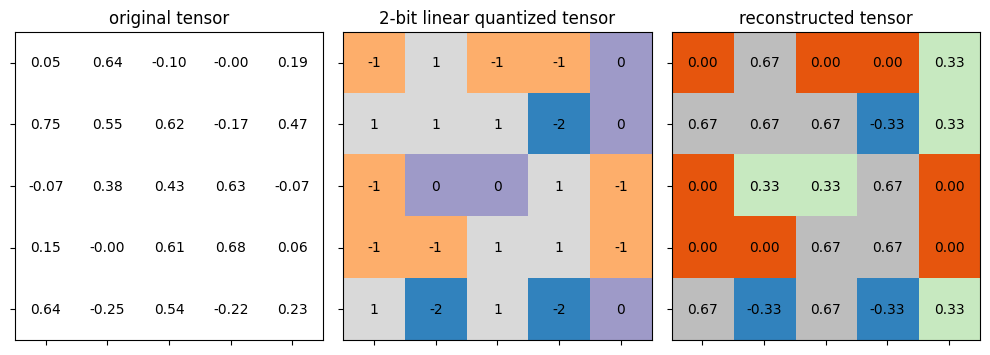

In [25]:
test_linear_quantize()

## Question 5 (10 pts)

Now we have to determine the scaling factor $S$ and zero point $Z$ for linear quantization.

Recall that [linear quantization](https://arxiv.org/pdf/1712.05877.pdf) can be represented as

$r = S(q-Z)$

### Scale

Linear quantization projects the floating point range [*fp_min*, *fp_max*] to the quantized range [*quantized_min*, *quantized_max*]. That is to say,

> $r_{\mathrm{max}} = S(q_{\mathrm{max}}-Z)$
>
> $r_{\mathrm{min}} = S(q_{\mathrm{min}}-Z)$

Substracting these two equations, we have,


#### Question 5.1 (1 pts)

Please select the correct answer and delete the wrong answers in the next text cell.

> $S=r_{\mathrm{max}} / q_{\mathrm{max}}$

> $S=(r_{\mathrm{max}} + r_{\mathrm{min}}) / (q_{\mathrm{max}} + q_{\mathrm{min}})$

> $S=(r_{\mathrm{max}} - r_{\mathrm{min}}) / (q_{\mathrm{max}} - q_{\mathrm{min}})$ 对

> $S=r_{\mathrm{max}} / q_{\mathrm{max}} - r_{\mathrm{min}} / q_{\mathrm{min}}$


There are different approaches to determine the $r_{\mathrm{min}}$ and  $r_{\mathrm{max}}$ of a floating point tensor `fp_tensor`.

*   The most common method is directly using the minimum and maximum value of `fp_tensor`.
*   Another widely used method is minimizing Kullback-Leibler-J divergence to determine the *fp_max*.

### zero point

Once we determine the scaling factor $S$, we can directly use the relationship between $r_{\mathrm{min}}$ and $q_{\mathrm{min}}$ to calculate the zero point $Z$.

#### Question 5.2 (1 pts)

Please select the correct answer and delete the wrong answers in the next text cell.

> $Z = \mathrm{int}(\mathrm{round}(r_{\mathrm{min}} / S - q_{\mathrm{min}})$

> $Z = \mathrm{int}(\mathrm{round}(q_{\mathrm{min}} - r_{\mathrm{min}} / S))$

> $Z = q_{\mathrm{min}} - r_{\mathrm{min}} / S$对

> $Z = r_{\mathrm{min}} / S - q_{\mathrm{min}}$

### Question 5.3 (8 pts)

Please complete the following function for calculating the scale $S$ and zero point $Z$ from floating point tensor $r$.


In [26]:
def get_quantization_scale_and_zero_point(fp_tensor, bitwidth):
    """
    get quantization scale for single tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [float] scale
        [int] zero_point
    """
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fp_max = fp_tensor.max().item()
    fp_min = fp_tensor.min().item()

    ############### YOUR CODE STARTS HERE ###############
    # hint: one line of code for calculating scale
    scale = (fp_max - fp_min) / (quantized_max - quantized_min)
    # hint: one line of code for calculating zero_point
    zero_point = quantized_min - fp_min / scale
    ############### YOUR CODE ENDS HERE #################

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < quantized_min:
        zero_point = quantized_min
    elif zero_point > quantized_max:
        zero_point = quantized_max
    else: # convert from float to int using round()
        zero_point = round(zero_point)
    return scale, int(zero_point)

We now wrap  `linear_quantize()` in Question 4 and `get_quantization_scale_and_zero_point()` in Question 5 into one function.

In [27]:
def linear_quantize_feature(fp_tensor, bitwidth):
    """
    linear quantization for feature tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating feature to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [float] scale tensor
        [int] zero point
    """
    scale, zero_point = get_quantization_scale_and_zero_point(fp_tensor, bitwidth)
    quantized_tensor = linear_quantize(fp_tensor, bitwidth, scale, zero_point)
    return quantized_tensor, scale, zero_point

## Special case: linear quantization on weight tensor

Let's first see the distribution of weight values.

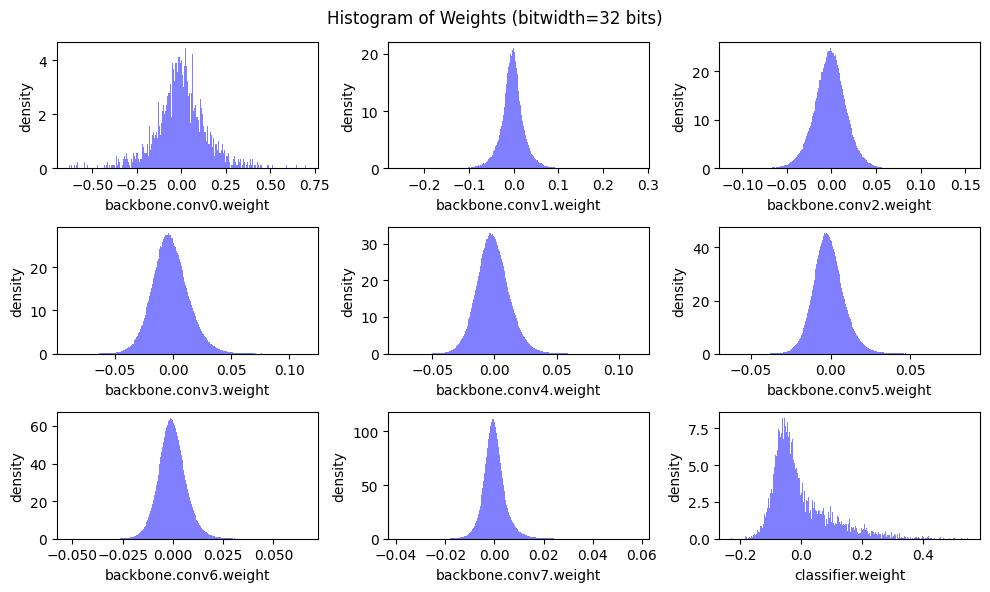

In [28]:
def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

recover_model()
plot_weight_distribution(model)

As we can see from the histograms above, the distribution of weight values are nearly symmetric about 0 (except for the classifier in this case). Therefore, we usually make zero point $Z=0$ when quantizating the weights.

From $r = S(q-Z)$, we have

> $r_{\mathrm{max}} = S \cdot q_{\mathrm{max}}$

and then

> $S = r_{\mathrm{max}} / q_{\mathrm{max}}$

We directly use the maximum magnitude of weight values as $r_{\mathrm{max}}$.

In [29]:
def get_quantization_scale_for_weight(weight, bitwidth):
    """
    get quantization scale for single tensor of weight
    :param weight: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [integer] quantization bit width
    :return:
        [floating scalar] scale
    """
    # we just assume values in weight are symmetric
    # we also always make zero_point 0 for weight
    fp_max = max(weight.abs().max().item(), 5e-7)
    _, quantized_max = get_quantized_range(bitwidth)
    return fp_max / quantized_max

### Per-channel Linear Quantization

Recall that for 2D convolution, the weight tensor is a 4-D tensor in the shape of (num_output_channels, num_input_channels, kernel_height, kernel_width).

Intensive experiments show that using the different scaling factors $S$ and zero points $Z$ for different output channels will perform better. Therefore, we have to determine scaling factor $S$ and zero point $Z$ for the subtensor of each output channel independently.

In [30]:
def linear_quantize_weight_per_channel(tensor, bitwidth):
    """
    linear quantization for weight tensor
        using different scales and zero_points for different output channels
    :param tensor: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [torch.(cuda.)Tensor] scale tensor
        [int] zero point (which is always 0)
    """
    dim_output_channels = 0
    num_output_channels = tensor.shape[dim_output_channels]
    scale = torch.zeros(num_output_channels, device=tensor.device)
    for oc in range(num_output_channels):
        _subtensor = tensor.select(dim_output_channels, oc)
        _scale = get_quantization_scale_for_weight(_subtensor, bitwidth)
        scale[oc] = _scale
    scale_shape = [1] * tensor.dim()
    scale_shape[dim_output_channels] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_quantize(tensor, bitwidth, scale, zero_point=0)
    return quantized_tensor, scale, 0

### A Quick Peek at Linear Quantization on Weights

Now let's have a peek on the weight distribution and model size when applying linear quantization on weights with different bitwidths.

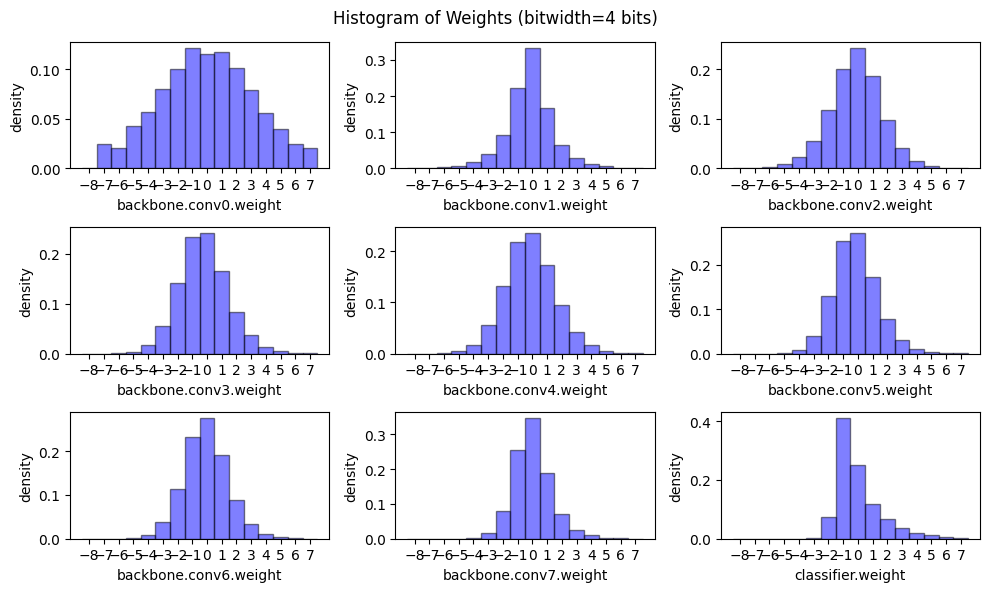

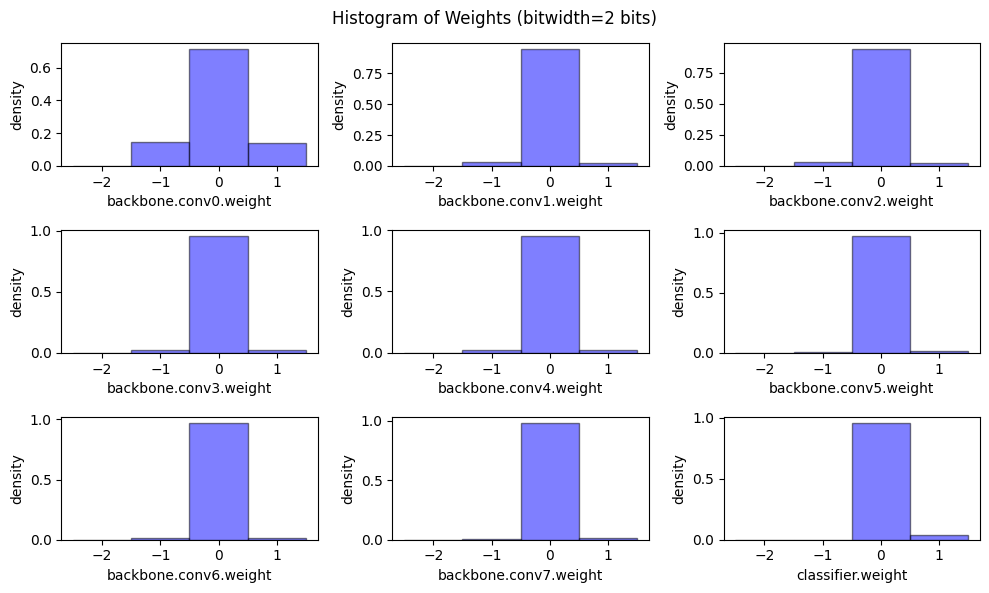

In [31]:
@torch.no_grad()
def peek_linear_quantization():
    for bitwidth in [4, 2]:
        for name, param in model.named_parameters():
            if param.dim() > 1:
                quantized_param, scale, zero_point = \
                    linear_quantize_weight_per_channel(param, bitwidth)
                param.copy_(quantized_param)
        plot_weight_distribution(model, bitwidth)
        recover_model()

peek_linear_quantization()

## Quantized Inference

After quantization, the inference of convolution and fully-connected layers also change.

Recall that $r = S(q-Z)$, and we have

> $r_{\mathrm{input}} = S_{\mathrm{input}}(q_{\mathrm{input}}-Z_{\mathrm{input}})$
>
> $r_{\mathrm{weight}} = S_{\mathrm{weight}}(q_{\mathrm{weight}}-Z_{\mathrm{weight}})$
>
> $r_{\mathrm{bias}} = S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})$

Since $Z_{\mathrm{weight}}=0$, $r_{\mathrm{weight}} = S_{\mathrm{weight}}q_{\mathrm{weight}}$.

The floating point convolution can be written as,

> $r_{\mathrm{output}} = \mathrm{CONV}[r_{\mathrm{input}}, r_{\mathrm{weight}}] + r_{\mathrm{bias}}\\
\;\;\;\;\;\;\;\;= \mathrm{CONV}[S_{\mathrm{input}}(q_{\mathrm{input}}-Z_{\mathrm{input}}), S_{\mathrm{weight}}q_{\mathrm{weight}}] + S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})\\
\;\;\;\;\;\;\;\;= \mathrm{CONV}[q_{\mathrm{input}}-Z_{\mathrm{input}}, q_{\mathrm{weight}}]\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}}) + S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})$

To further simplify the computation, we could let

> $Z_{\mathrm{bias}} = 0$
>
> $S_{\mathrm{bias}} = S_{\mathrm{input}} \cdot S_{\mathrm{weight}}$

so that

> $r_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}-Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}})$
> $\;\;\;\;\;\;\;\;= (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}}S_{\mathrm{weight}})$

Since
> $r_{\mathrm{output}} = S_{\mathrm{output}}(q_{\mathrm{output}}-Z_{\mathrm{output}})$

we have
> $S_{\mathrm{output}}(q_{\mathrm{output}}-Z_{\mathrm{output}}) = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} S_{\mathrm{weight}})$

and thus
> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

Since $Z_{\mathrm{input}}$, $q_{\mathrm{weight}}$, $q_{\mathrm{bias}}$ are determined before inference, let

> $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$

we have

> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}}) \cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

Similarily, for fully-connected layer, we have

> $q_{\mathrm{output}} = (\mathrm{Linear}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

where

> $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{Linear}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$

### Question 6 (5 pts)

Please complete the following function for linear quantizing the bias.

**Hint**:

From the above deduction, we know that

> $Z_{\mathrm{bias}} = 0$
>
> $S_{\mathrm{bias}} = S_{\mathrm{input}} \cdot S_{\mathrm{weight}}$

In [32]:
def linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale):
    """
    linear quantization for single bias tensor
        quantized_bias = fp_bias / bias_scale
    :param bias: [torch.FloatTensor] bias weight to be quantized
    :param weight_scale: [float or torch.FloatTensor] weight scale tensor
    :param input_scale: [float] input scale
    :return:
        [torch.IntTensor] quantized bias tensor
    """
    assert(bias.dim() == 1)
    assert(bias.dtype == torch.float)
    assert(isinstance(input_scale, float))
    if isinstance(weight_scale, torch.Tensor):
        assert(weight_scale.dtype == torch.float)
        weight_scale = weight_scale.view(-1)
        assert(bias.numel() == weight_scale.numel())

    ############### YOUR CODE STARTS HERE ###############
    # hint: one line of code
    bias_scale = input_scale * weight_scale
    ############### YOUR CODE ENDS HERE #################

    quantized_bias = linear_quantize(bias, 32, bias_scale,
                                     zero_point=0, dtype=torch.int32)
    return quantized_bias, bias_scale, 0

### Quantized Fully-Connected Layer

For quantized fully-connected layer, we first precompute $Q_{\mathrm{bias}}$. Recall that $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{Linear}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$.

In [33]:
def shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Linear
        shifted_quantized_bias = quantized_bias - Linear(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum(1).to(torch.int32) * input_zero_point

#### Question 7 (15 pts)

Please complete the following quantized fully-connected layer inference function.

**Hint**:

> $q_{\mathrm{output}} = (\mathrm{Linear}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

In [34]:
def quantized_linear(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale):
    """
    quantized fully-connected layer
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param output_zero_point: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.CharIntTensor] quantized output feature (torch.int8)
    """
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: integer-based fully-connected (8-bit multiplication with 32-bit accumulation)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.linear(input.to(torch.int32), weight.to(torch.int32), bias)
    else:
        # current version pytorch does not yet support integer-based linear() on GPUs
        output = torch.nn.functional.linear(input.float(), weight.float(), bias.float())

    ############### YOUR CODE STARTS HERE ###############
    # Step 2: scale the output
    #         hint: 1. scales are floating numbers, we need to convert output to float as well
    #               2. the shape of weight scale is [oc, 1, 1, 1] while the shape of output is [batch_size, oc]
    final_scale = input_scale * weight_scale.view(1, -1) / output_scale
    output = output.float() * final_scale

    # Step 3: shift output by output_zero_point
    #         hint: one line of code
    output = output + output_zero_point
    ############### YOUR CODE ENDS HERE #################

    # Make sure all value lies in the bitwidth-bit range
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

Let's verify the functionality of defined quantized fully connected layer.

* Test quantized_fc()
    target bitwidth: 2 bits
      batch size: 4
      input channels: 8
      output channels: 8
* Test passed.


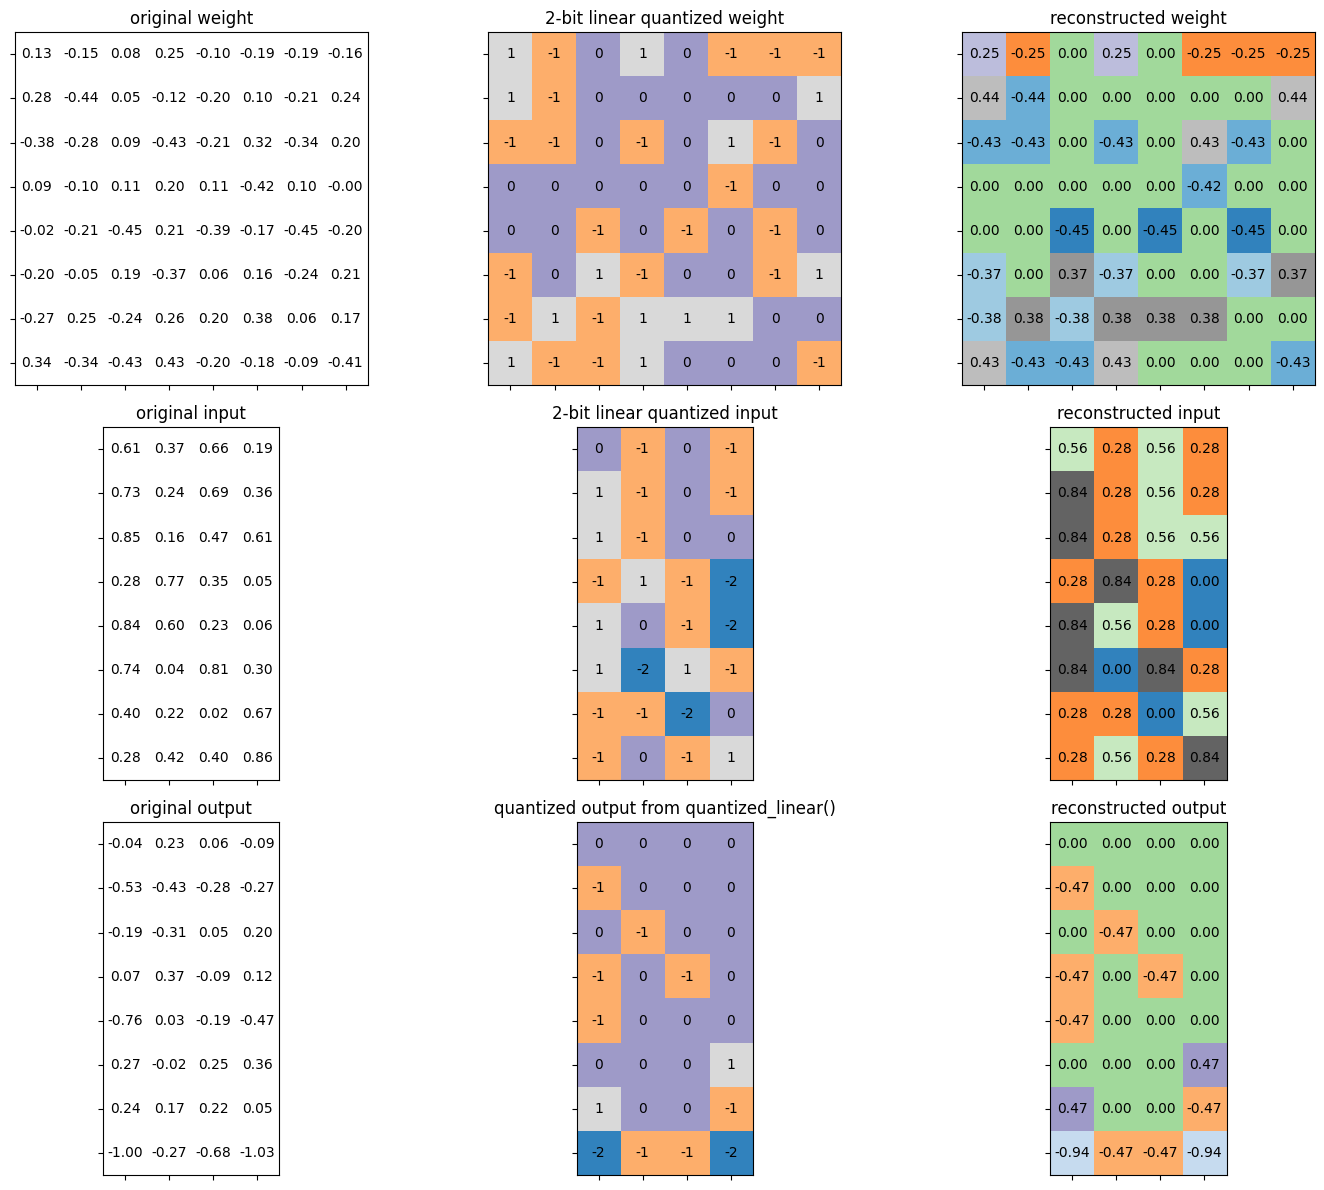

In [35]:
test_quantized_fc()

### Quantized Convolution

For quantized convolution layer, we first precompute $Q_{\mathrm{bias}}$. Recall that $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$.

In [36]:
def shift_quantized_conv2d_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Conv2d
        shifted_quantized_bias = quantized_bias - Conv(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum((1,2,3)).to(torch.int32) * input_zero_point

#### Question 8 (15 pts)

Please complete the following quantized convolution function.

**Hint**:
> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}}) \cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$


In [37]:
def quantized_conv2d(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale,
                     stride, padding, dilation, groups):
    """
    quantized 2d convolution
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param output_zero_point: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.(cuda.)CharTensor] quantized output feature
    """
    assert(len(padding) == 4)
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: calculate integer-based 2d convolution (8-bit multiplication with 32-bit accumulation)
    input = torch.nn.functional.pad(input, padding, 'constant', input_zero_point)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.conv2d(input.to(torch.int32), weight.to(torch.int32), None, stride, 0, dilation, groups)
    else:
        # current version pytorch does not yet support integer-based conv2d() on GPUs
        output = torch.nn.functional.conv2d(input.float(), weight.float(), None, stride, 0, dilation, groups)
        output = output.round().to(torch.int32)
    if bias is not None:
        output = output + bias.view(1, -1, 1, 1)

    ############### YOUR CODE STARTS HERE ###############
    # hint: this code block should be the very similar to quantized_linear()

    # Step 2: scale the output
    #         hint: 1. scales are floating numbers, we need to convert output to float as well
    #               2. the shape of weight scale is [oc, 1, 1, 1] while the shape of output is [batch_size, oc, height, width]
    # print("input_scale: ", input_scale)
    # print("weight_scale: ", weight_scale.shape)
    # print("output_scale: ", output_scale)
    # print("output: ", output.shape)
    final_scale = (input_scale * weight_scale.squeeze() / output_scale).unsqueeze(-1).unsqueeze(-1)
    # print("final_scale: ", final_scale.shape)
    output = output.float() * final_scale
    # print("output_after: ", output)

    # Step 3: shift output by output_zero_point in conv
    #         hint: one line of code
    output = output + output_zero_point
    ############### YOUR CODE ENDS HERE #################

    # Make sure all value lies in the bitwidth-bit range
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

## Question 9 (10 pts)

Finally, we are putting everything together and perform post-training `int8` quantization for the model. We will convert the convolutional and linear layers in the model to a quantized version one-by-one.

1. Firstly, we will fuse a BatchNorm layer into its previous convolutional layer, which is a standard practice before quantization. Fusing batchnorm reduces the extra multiplication during inference.

We will also verify that the fused model `model_fused` has the same accuracy as the original model (BN fusion is an equivalent transform that does not change network functionality).

In [38]:
def fuse_conv_bn(conv, bn):
    # modified from https://mmcv.readthedocs.io/en/latest/_modules/mmcv/cnn/utils/fuse_conv_bn.html
    assert conv.bias is None

    factor = bn.weight.data / torch.sqrt(bn.running_var.data + bn.eps)
    conv.weight.data = conv.weight.data * factor.reshape(-1, 1, 1, 1)
    conv.bias = nn.Parameter(- bn.running_mean.data * factor + bn.bias.data)

    return conv

print('Before conv-bn fusion: backbone length', len(model.backbone))
#  fuse the batchnorm into conv layers
recover_model()
model_fused = copy.deepcopy(model)
fused_backbone = []
ptr = 0
while ptr < len(model_fused.backbone):
    if isinstance(model_fused.backbone[ptr], nn.Conv2d) and \
        isinstance(model_fused.backbone[ptr + 1], nn.BatchNorm2d):
        fused_backbone.append(fuse_conv_bn(
            model_fused.backbone[ptr], model_fused.backbone[ptr+ 1]))
        ptr += 2
    else:
        fused_backbone.append(model_fused.backbone[ptr])
        ptr += 1
model_fused.backbone = nn.Sequential(*fused_backbone)

print('After conv-bn fusion: backbone length', len(model_fused.backbone))
# sanity check, no BN anymore
for m in model_fused.modules():
    assert not isinstance(m, nn.BatchNorm2d)

#  the accuracy will remain the same after fusion
fused_acc = evaluate(model_fused, dataloader['test'])
print(f'Accuracy of the fused model={fused_acc:.2f}%')

Before conv-bn fusion: backbone length 29
After conv-bn fusion: backbone length 21


Accuracy of the fused model=92.95%


2. We will run the model with some sample data to get the range of each feature map, so that we can get the range of the feature maps and compute their corresponding scaling factors and zero points.

In [39]:
# add hook to record the min max value of the activation
input_activation = {}
output_activation = {}

def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        input_activation[module_name] = x.detach()
        output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ReLU)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))
    return all_hooks

hooks = add_range_recoder_hook(model_fused)
sample_data = iter(dataloader['train']).__next__()[0]
model_fused(sample_data.cuda())

# remove hooks
for h in hooks:
    h.remove()


3. Finally, let's do model quantization. We will convert the model in the following mapping
```python
nn.Conv2d: QuantizedConv2d,
nn.Linear: QuantizedLinear,
# the following twos are just wrappers, as current
# torch modules do not support int8 data format;
# we will temporarily convert them to fp32 for computation
nn.MaxPool2d: QuantizedMaxPool2d,
nn.AvgPool2d: QuantizedAvgPool2d,
```

In [40]:
class QuantizedConv2d(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 stride, padding, dilation, groups,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.stride = stride
        self.padding = (padding[1], padding[1], padding[0], padding[0])
        self.dilation = dilation
        self.groups = groups

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth


    def forward(self, x):
        return quantized_conv2d(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale,
            self.stride, self.padding, self.dilation, self.groups
            )

class QuantizedLinear(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth

    def forward(self, x):
        return quantized_linear(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale
            )

class QuantizedMaxPool2d(nn.MaxPool2d):
    def forward(self, x):
        # current version PyTorch does not support integer-based MaxPool
        return super().forward(x.float()).to(torch.int8)

class QuantizedAvgPool2d(nn.AvgPool2d):
    def forward(self, x):
        # current version PyTorch does not support integer-based AvgPool
        return super().forward(x.float()).to(torch.int8)

# we use int8 quantization, which is quite popular
feature_bitwidth = weight_bitwidth = 8
quantized_model = copy.deepcopy(model_fused)
quantized_backbone = []
ptr = 0
while ptr < len(quantized_model.backbone):
    if isinstance(quantized_model.backbone[ptr], nn.Conv2d) and \
        isinstance(quantized_model.backbone[ptr + 1], nn.ReLU):
        conv = quantized_model.backbone[ptr]
        conv_name = f'backbone.{ptr}'
        relu = quantized_model.backbone[ptr + 1]
        relu_name = f'backbone.{ptr + 1}'

        input_scale, input_zero_point = \
            get_quantization_scale_and_zero_point(
                input_activation[conv_name], feature_bitwidth)

        output_scale, output_zero_point = \
            get_quantization_scale_and_zero_point(
                output_activation[relu_name], feature_bitwidth)

        quantized_weight, weight_scale, weight_zero_point = \
            linear_quantize_weight_per_channel(conv.weight.data, weight_bitwidth)
        quantized_bias, bias_scale, bias_zero_point = \
            linear_quantize_bias_per_output_channel(
                conv.bias.data, weight_scale, input_scale)
        shifted_quantized_bias = \
            shift_quantized_conv2d_bias(quantized_bias, quantized_weight,
                                        input_zero_point)

        quantized_conv = QuantizedConv2d(
            quantized_weight, shifted_quantized_bias,
            input_zero_point, output_zero_point,
            input_scale, weight_scale, output_scale,
            conv.stride, conv.padding, conv.dilation, conv.groups,
            feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
        )

        quantized_backbone.append(quantized_conv)
        ptr += 2
    elif isinstance(quantized_model.backbone[ptr], nn.MaxPool2d):
        quantized_backbone.append(QuantizedMaxPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    elif isinstance(quantized_model.backbone[ptr], nn.AvgPool2d):
        quantized_backbone.append(QuantizedAvgPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    else:
        raise NotImplementedError(type(quantized_model.backbone[ptr]))  # should not happen
quantized_model.backbone = nn.Sequential(*quantized_backbone)

# finally, quantized the classifier
fc_name = 'classifier'
fc = model.classifier
input_scale, input_zero_point = \
    get_quantization_scale_and_zero_point(
        input_activation[fc_name], feature_bitwidth)

output_scale, output_zero_point = \
    get_quantization_scale_and_zero_point(
        output_activation[fc_name], feature_bitwidth)

quantized_weight, weight_scale, weight_zero_point = \
    linear_quantize_weight_per_channel(fc.weight.data, weight_bitwidth)
quantized_bias, bias_scale, bias_zero_point = \
    linear_quantize_bias_per_output_channel(
        fc.bias.data, weight_scale, input_scale)
shifted_quantized_bias = \
    shift_quantized_linear_bias(quantized_bias, quantized_weight,
                                input_zero_point)

quantized_model.classifier = QuantizedLinear(
    quantized_weight, shifted_quantized_bias,
    input_zero_point, output_zero_point,
    input_scale, weight_scale, output_scale,
    feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
)

The quantization process is done! Let's print and visualize the model architecture and also verify the accuracy of the quantized model.


### Question 9.1 (5 pts)

To run the quantized model, we need an extra preprocessing to map the input data from range (0, 1) into `int8` range of (-128, 127). Fill in the code below to finish the extra preprocessing.

**Hint**: you should find that the quantized model has roughly the same accuracy as the `fp32` counterpart.

In [42]:
print(model)
print(quantized_model)

def extra_preprocess(x):
    # hint: you need to convert the original fp32 input of range (0, 1)
    #  into int8 format of range (-128, 127)
    ############### YOUR CODE STARTS HERE ###############
    return (x * 255 - 128).clamp(-128, 127).to(torch.int8)
    ############### YOUR CODE ENDS HERE #################

int8_model_accuracy = evaluate(quantized_model, dataloader['test'],
                               extra_preprocess=[extra_preprocess])
print(f"int8 model has accuracy={int8_model_accuracy:.2f}%")

VGG(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool1): MaxPo

int8 model has accuracy=92.90%


## Question 9.2 (Bonus Question; 5 pts)

Explain why there is no ReLU layer in the linear quantized model.

**Your Answer:**

https://www.cnblogs.com/jermmyhsu/p/14459892.html

ReLU 除了做数值上的截断外，其实没有其他操作了，而量化本身自带截断操作，因此才能把 ReLU 合并到 Conv 或者 FC 等操作里面

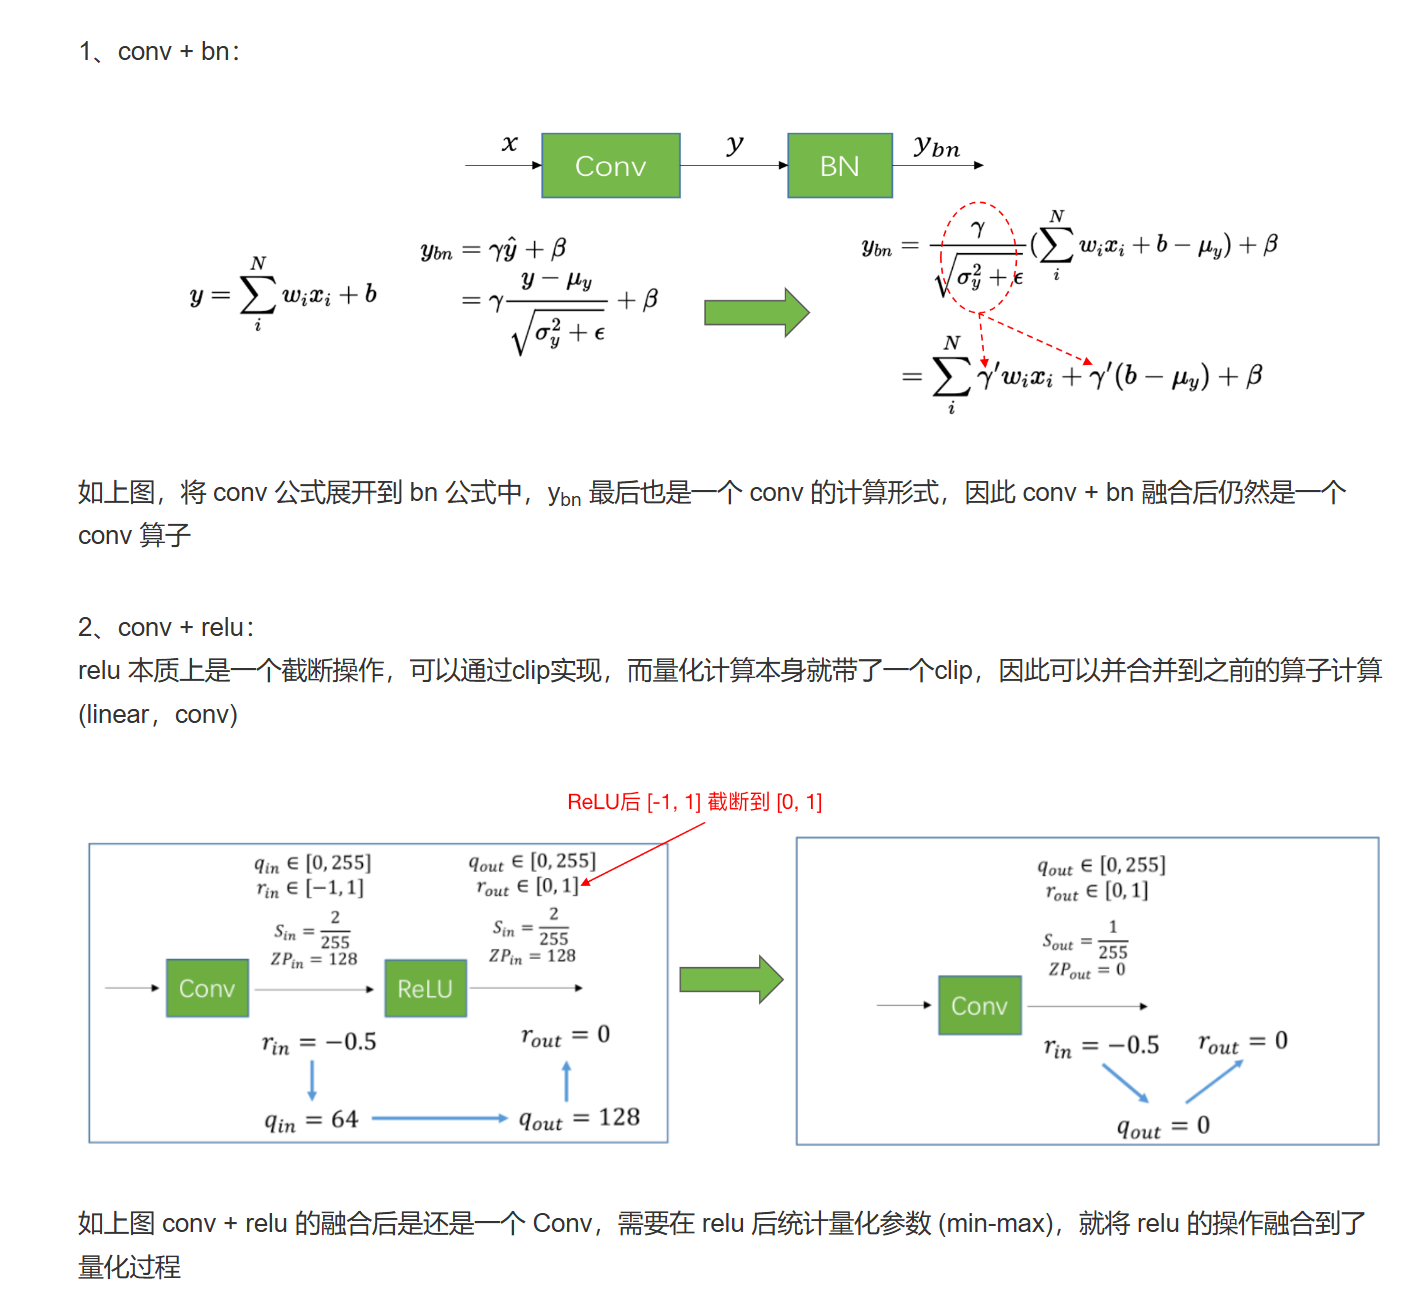

# Question 10 (5 pts)

Please compare the advantages and disadvantages of k-means-based quantization and linear quantization. You can discuss from the perspective of accuracy, latency, hardware support, etc.

**Your Answer:**

kmeans：更能代表原始分布，减少信息丢失，模型更小，可以适应更多数据分布情况，但是计算很慢，硬件难以支持
linear：广泛支持，运算更简单，准确性低

# Feedback

Please fill out this [feedback form](https://forms.gle/ZeCH5anNPrkd5wpp7) when you finished this lab. We would love to hear your thoughts or feedback on how we can improve this lab!